In [1]:
# inspiration from NMT
# i have used 'vendor name' as start token to the decoder.
# as we can see this model is overfitting to the train data

In [1]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data=pd.read_csv('deep_learning_features.csv')
data['canonical_vendor_name'] =data['canonical_vendor_name'].replace(' ', '_', regex=True)
data['line_item_nd']=data['line_item_nd'].str.strip()
data['canonical_vendor_name']=data['canonical_vendor_name'].str.strip()
data['canonical_line_item_name_y']=data['canonical_line_item_name_y'].str.strip()
data.head()

,line_item_nd,canonical_vendor_name,canonical_line_item_name_y,Y
0,management services april #### services,##_minute_ventures,management services,1
1,june web media fee ### ### times ## percent co...,acqcom_digital_marketing,web media fee,1
2,business package,adjust,additional attributions,0
3,business package,adjust,business package,1
4,seo services,adlift,content marketing,0


In [3]:
all_strings = []
for k in data.columns:
    if not k=='Y':
        strings=('\n'.join(data[k])).split('\n')
        all_strings.extend(strings)

In [4]:
def concat(x):
    x,y = x[0],x[1]
    return x.strip()+" "+y.strip()
    
data['item_name_x'] = data[['canonical_vendor_name','canonical_line_item_name_y']].apply(lambda x: concat(x),axis=1)

In [5]:
data['item_name_y'] = data['canonical_line_item_name_y'].apply( lambda x: x+" <END>")
data.drop(['canonical_line_item_name_y','canonical_vendor_name'], axis=1, inplace=True)

In [6]:
'##_minute_ventures' in all_strings, type(all_strings), all_strings.index('##_minute_ventures'), all_strings[12089]

(True, list, 12089, '##_minute_ventures')

In [7]:
data=data[data['Y']==1]

In [8]:
data.shape

(483, 4)

In [9]:
X_train=data.drop(['Y'], axis=1)
Y_train=data['Y']

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_eval, Y_train, Y_eval = train_test_split(X_train, Y_train, test_size=0.2, stratify=Y_train)

In [11]:
t = Tokenizer(filters='!"$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
t.fit_on_texts(all_strings)

In [12]:
t.word_index['##_minute_ventures']

1776

In [13]:
lengths_x=(X_train['line_item_nd'].str.split().apply(len)).values
lengths_y=(X_train['item_name_x'].str.split().apply(len)).values

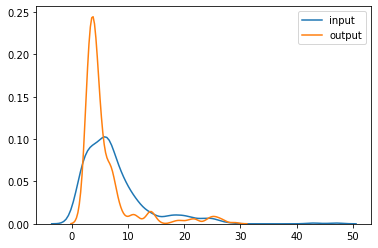

In [14]:
sns.kdeplot(lengths_x, label="input")
sns.kdeplot(lengths_y, label="output")
plt.show()

In [15]:
print(np.argmax(lengths_x), X_train.iloc[np.argmax(lengths_x)])
print(np.argmax(lengths_y), X_train.iloc[np.argmax(lengths_y)])
for i in range(0, 101, 10):
    print(i, np.percentile(lengths_x, i), np.percentile(lengths_y, i))

169 line_item_nd    lenovo thinkpad x# carbon #th gen ##qd ultrabo...
item_name_x     sti_products lenovo thinkpad x# carbon #th gen...
item_name_y          lenovo thinkpad x# carbon #th gen ##qd <END>
Name: 9934, dtype: object
303 line_item_nd    ixcc extra long iphone charger cable ## feet l...
item_name_x     amazon_business ixcc extra long iphone charger...
item_name_y     ixcc extra long iphone charger cable ## feet l...
Name: 4002, dtype: object
0 0.0 2.0
10 2.0 3.0
20 3.0 3.0
30 4.0 4.0
40 5.0 4.0
50 6.0 4.0
60 7.0 5.0
70 8.0 5.5
80 10.0 7.0
90 14.5 11.0
100 47.0 29.0


In [16]:
for i in range(90, 101, 1):
    print(i, np.percentile(lengths_x, i), np.percentile(lengths_y, i))

90 14.5 11.0
91 16.350000000000023 11.350000000000023
92 17.19999999999999 14.0
93 18.0 14.0
94 19.0 14.0
95 20.0 18.75
96 21.0 21.0
97 23.0 22.899999999999977
98 24.30000000000001 25.0
99 26.0 26.0
100 47.0 29.0


In [17]:
input_encoder_train = t.texts_to_sequences(X_train['line_item_nd'])
input_encoder_train = pad_sequences(input_encoder_train, maxlen=25,padding='post')
print("input dimes",input_encoder_train.shape)

input_decoder_train = t.texts_to_sequences(X_train['item_name_x'])
input_decoder_train = pad_sequences(input_decoder_train, maxlen=25,padding='post')
print("link item",input_decoder_train.shape)

output_decoder_train = t.texts_to_sequences(X_train['item_name_y'])
output_decoder_train = pad_sequences(output_decoder_train, maxlen=25,padding='post')
print("link item",output_decoder_train.shape)

#====================
input_encoder_eval = t.texts_to_sequences(X_eval['line_item_nd'])
input_encoder_eval = pad_sequences(input_encoder_eval, maxlen=25,padding='post')
print("input dimes",input_encoder_eval.shape)

input_decoder_eval = t.texts_to_sequences(X_eval['item_name_x'])
input_decoder_eval = pad_sequences(input_decoder_eval, maxlen=25,padding='post')
print("link item",input_decoder_eval.shape)

output_decoder_eval = t.texts_to_sequences(X_eval['item_name_y'])
output_decoder_eval = pad_sequences(output_decoder_eval, maxlen=25,padding='post')
print("link item",output_decoder_eval.shape)
#====================


input dimes (386, 25)
link item (386, 25)
link item (386, 25)
input dimes (97, 25)
link item (97, 25)
link item (97, 25)


In [18]:
# !wget http://nlp.stanford.edu/data/glove.42B.300d.zip
# !unzip glove.42B.300d.zip

In [19]:
vocab = set(dict(t.word_index.items()).keys())

In [20]:
vocab_size = len(t.word_index) + 1

In [21]:
embeddings_index = {}
with open('glove.42B.300d.txt', 'r') as f:
    for line in f:
        values = line.split()
        word  = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        if word in vocab:
            embeddings_index[word] = coefs

print('Found word vectors ', len(embeddings_index), "out of", vocab_size)
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Found word vectors  1657 out of 1822


In [22]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dot, Dense, Dropout
from tensorflow.keras.models import Model

In [23]:
from sklearn.metrics import roc_auc_score
def auroc(y_true, y_pred):
    y_true= tf.reshape(y_true, shape=(-1,))
    if tf.unique(y_true)[0].shape[0]==1:
        print(tf.unique(y_true)[0].shape, "hello")
        return 0.5
    else:
        return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)

In [24]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, input_length, enc_units):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.input_length = input_length
        self.enc_units= enc_units
        self.lstm_output = 0
        self.state_h=0
        self.state_c=0
        
    def build(self, input_shape):
        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim, input_length=self.input_length,
                           mask_zero=True, name="embedding_layer_encoder", weights=[embedding_matrix], trainable=False)
        self.lstm = LSTM(self.enc_units, return_state=True, return_sequences=True, name="Encoder_LSTM")
        
    def call(self, input_sentances, training=True):
        # print("ENCODER ==> INPUT SQUENCES SHAPE :",input_sentances.shape)
        input_embedd                           = self.embedding(input_sentances)
        # print("ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE :",input_embedd.shape)
        self.lstm_output, self.lstm_state_h,self.lstm_state_c = self.lstm(input_embedd)
        return self.lstm_output, self.lstm_state_h,self.lstm_state_c
    def get_states(self):
        return self.state_h,self.state_c
    
class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, input_length, dec_units):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.dec_units = dec_units
        self.input_length = input_length

    def build(self, input_shape):
        self.embedding = Embedding(input_dim= self.vocab_size, output_dim=self.embedding_dim, input_length=input_shape,
                           mask_zero=True, name="embedding_layer_decoder", weights=[embedding_matrix], trainable=False)
        self.lstm = LSTM(self.dec_units, return_sequences=True, return_state=True, name="Encoder_LSTM")
        
    def call(self, target_sentances, state_h, state_c):
        # print("DECODER ==> INPUT SQUENCES SHAPE :",target_sentances.shape)
        target_embedd           = self.embedding(target_sentances)
        # print("WE ARE INITIALIZING DECODER WITH ENCODER STATES :",state_h.shape, state_c.shape)
        lstm_output, _,_        = self.lstm(target_embedd, initial_state=[state_h, state_c])
        return lstm_output

In [25]:
class MyModel(Model):
    def __init__(self, encoder_inputs_length,decoder_inputs_length, output_vocab_size):
        super().__init__() # https://stackoverflow.com/a/27134600/4084039
        self.encoder = Encoder(vocab_size=vocab_size, embedding_dim=300, input_length=encoder_inputs_length, enc_units=100)
        self.decoder = Decoder(vocab_size=vocab_size, embedding_dim=300, input_length=decoder_inputs_length, dec_units=100)
        self.dense   = Dense(output_vocab_size, activation='softmax')
        self.drop  = Dropout(rate=0.4)
        
    def call(self, data):
        input,output = data[0], data[1]
        # print("="*20, "ENCODER", "="*20)
        encoder_output, encoder_h, encoder_c = self.encoder(input)
        # print("-"*27)
        # print("ENCODER ==> OUTPUT SHAPE",encoder_output.shape)
        # print("ENCODER ==> HIDDEN STATE SHAPE",encoder_h.shape)
        # print("ENCODER ==> CELL STATE SHAPE", encoder_c.shape)
        # print("="*20, "DECODER", "="*20)
        decoder_output                       = self.decoder(output, encoder_h, encoder_c)
        dropout                              = self.drop(decoder_output)
        output                               = self.dense(dropout)
        # print("-"*27)
        # print("FINAL OUTPUT SHAPE",output.shape)
        # print("="*50)
        return output
without_vendor  = MyModel(encoder_inputs_length=25,decoder_inputs_length=25,output_vocab_size=vocab_size)

In [26]:
# loss_object = loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
optimizer = tf.keras.optimizers.Adam()

without_vendor.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy')

without_vendor.fit([input_encoder_train, input_decoder_train], output_decoder_train, epochs=100, \
          validation_data=([input_encoder_eval, input_decoder_eval], output_decoder_eval),\
          )
without_vendor.summary()

Epoch 1/100
13/13 [==============================] - 4s 293ms/step - loss: 1.7433 - val_loss: 1.6893
Epoch 2/100
13/13 [==============================] - 2s 132ms/step - loss: 1.5735 - val_loss: 1.4800
Epoch 3/100
13/13 [==============================] - 2s 132ms/step - loss: 1.3324 - val_loss: 1.4007
Epoch 4/100
13/13 [==============================] - 2s 130ms/step - loss: 1.2553 - val_loss: 1.4157
Epoch 5/100
13/13 [==============================] - 2s 131ms/step - loss: 1.2273 - val_loss: 1.4085
Epoch 6/100
13/13 [==============================] - 2s 132ms/step - loss: 1.2044 - val_loss: 1.3926
Epoch 7/100
13/13 [==============================] - 2s 131ms/step - loss: 1.1811 - val_loss: 1.3761
Epoch 8/100
13/13 [==============================] - 2s 135ms/step - loss: 1.1549 - val_loss: 1.3572
Epoch 9/100
13/13 [==============================] - 2s 132ms/step - loss: 1.1382 - val_loss: 1.3470
Epoch 10/100
13/13 [==============================] - 2s 135ms/step - loss: 1.1149 - val_lo

In [27]:
print("=" * 30, "Inference", "=" * 30)
print(input_encoder_train[0])
print(t.word_index['##_minute_ventures'])
enc_output, enc_state_h, enc_state_c = without_vendor.layers[0](np.expand_dims(input_encoder_train[0], 0))
states_values = [enc_state_h, enc_state_c]
pred = []
cur_vec = np.array([[1776]])
print('-'*20,"started predition","-"*20)
print("at time step 0 the word is ", t.index_word[1776])
for i in range(25):
    cur_emb = without_vendor.layers[1].embedding(cur_vec)
    [infe_output, state_h, state_c] = without_vendor.layers[1].lstm(cur_emb, initial_state=states_values)
    states_values = [state_h, state_c]
    # np.argmax(infe_output) will be a single value, which represents the the index of predicted word
    # but to pass this data into next time step embedding layer, we are reshaping it into (1,1) shape
    cur_vec = np.reshape(np.argmax(infe_output), (1, 1))
    print("at time step 0 the word is ", cur_vec, t.index_word[cur_vec[0][0]])
    pred.append(cur_vec)

============================== Inference ==============================
[1498 1499    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]
1776
-------------------- started predition --------------------
at time step 0 the word is  ##_minute_ventures
at time step 0 the word is  [[42]] disposable
at time step 0 the word is  [[78]] charge
at time step 0 the word is  [[25]] macbook
at time step 0 the word is  [[93]] camera
at time step 0 the word is  [[25]] macbook
at time step 0 the word is  [[25]] macbook
at time step 0 the word is  [[25]] macbook
at time step 0 the word is  [[25]] macbook
at time step 0 the word is  [[25]] macbook
at time step 0 the word is  [[25]] macbook
at time step 0 the word is  [[25]] macbook
at time step 0 the word is  [[79]] annual
at time step 0 the word is  [[62]] data
at time step 0 the word is  [[70]] disks
at time step 0 the word is  [[70]] disks
at time step 0 the word is  [[70]] disks
at time s